# 1. Import data and packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import factorial
from kneed import KneeLocator
from scipy.signal import savgol_filter

In [2]:
# Import data
day_ahead_prices_df = pd.read_csv('.\Data\Final\day_ahead_final.csv', sep=';', header=0, index_col=0)
daily_prices_df = pd.read_csv('.\Data\Final\daily_prices_final.csv', sep=';', header=0, index_col=0)
generation_df = pd.read_csv('.\Data\Final\generation_final.csv', sep=';', header=0, index_col=0)
production_type_df = pd.read_csv('.\Data\Final\production_type_final.csv', sep=';', header=0, index_col=0)
outages_df = pd.read_csv('.\Data\Final\outages_final.csv', sep=';', header=0, index_col=0)
plant_info_df = pd.read_excel('.\Data\Final\plant_info.xlsx', index_col=0)

In [3]:
# Dates to datetime
day_ahead_prices_df.index = pd.to_datetime(day_ahead_prices_df.index, utc=True).tz_convert('CET')
daily_prices_df.index = pd.to_datetime(daily_prices_df.index, utc=True).tz_convert('CET')
generation_df.index = pd.to_datetime(generation_df.index, utc=True).tz_convert('CET')
production_type_df.index = pd.to_datetime(production_type_df.index, utc=True).tz_convert('CET')
outages_df['start'] = pd.to_datetime(outages_df['start'], utc=True).dt.tz_convert('CET')
outages_df['end'] = pd.to_datetime(outages_df['end'], utc=True).dt.tz_convert('CET')

In [4]:
# Check
plant_info_df

,owner,type,available_capacity (MW),market_based
plant_name,,,,
Zelzate Knippegroen,Engie Electrabel/Arcelor Mittal,CL,315.0,0
Amercoeur,Engie Electrabel,CCGT,451.0,1
Drogenbos,Engie Electrabel,CCGT,460.0,1
Herdersbrug,Engie Electrabel,CCGT,480.3,1
Saint-Ghislain,Engie Electrabel,CCGT,386.0,1
Vilvoorde,Engie Electrabel,CCGT,385.0,1
Zandvliet,Engie Electrabel,CCGT,386.2,1
Inesco,Essent/Ineos,CHP,138.1,0
Marcinelle Energie (Carsid),Direct Energie,CCGT,413.0,1


In [5]:
# Set figure parameters
plt.rcParams['figure.figsize'] = [8, 4]

In [6]:
# Set data from 2017-10-23
day_ahead_prices_df = day_ahead_prices_df['2017-10-23':]
gas_prices_daily_df = daily_prices_df['2017-10-23':].drop(['day_ahead_price'], axis=1)
generation_df = generation_df['2017-10-23':]
production_type_df = production_type_df['2017-10-23':]
daily_prices_df = daily_prices_df['2017-10-23':]

In [7]:
# Join day ahead and gas price (per hour)
hourly_prices_df = day_ahead_prices_df.join(gas_prices_daily_df).fillna(method='ffill')

In [59]:
# Check
hourly_prices_df.head(5)

,day_ahead_price,gas_price
date,,
2017-10-23 00:00:00+02:00,65.805000,18.09
2017-10-24 00:00:00+02:00,52.650000,17.96
2017-10-25 00:00:00+02:00,58.244167,18.11
2017-10-26 00:00:00+02:00,64.522917,18.07
2017-10-27 00:00:00+02:00,53.442083,18.15


# 2. Feature Engineering

## Prices

In [9]:
# Create p_gas/p_elec
hourly_prices_df['p_gas/p_elec'] = round(hourly_prices_df['gas_price'] / hourly_prices_df['day_ahead_price'],2)

In [10]:
# Replace inf values for p_gas/p_elec with high number (will later be filtered out)
hourly_prices_df.replace(np.inf, 1000000, inplace=True)

In [11]:
# Check
hourly_prices_df[hourly_prices_df.index == '2020-06-28 13:00:00']

,day_ahead_price,gas_price,p_gas/p_elec
date,,,
2020-06-28 13:00:00+02:00,0.0,5.105,1000000.0


## Generation

In [12]:
# List of FG plants (list copied from Data_Cleaning)
fossil_gas_cols = ['Amercoeur 1 R GT', 'Amercoeur 1 R ST', 'DROGENBOS GT1', 'DROGENBOS GT2', 'DROGENBOS ST', 'EDF Luminus Seraing GT1', 'EDF Luminus Seraing GT2', 'HERDERSBRUG GT1', 'HERDERSBRUG GT2', 'HERDERSBRUG ST', 'INESCO WKK', 'Marcinelle Energie (Carsid)', 'RINGVAART STEG', 'SAINT-GHISLAIN STEG', 'SERAING TV', 'Scheldelaan Exxonmobil', 'T-power Beringen', 'VILVOORDE GT', 'VILVOORDE ST', 'Zandvliet Power', 'Zelzate 2 Knippegroen']

In [13]:
# Create df with FG generation plants
generation_fg_df = generation_df.loc[:, fossil_gas_cols]

In [14]:
# Check
generation_fg_df.head(1)

,Amercoeur 1 R GT,Amercoeur 1 R ST,DROGENBOS GT1,DROGENBOS GT2,DROGENBOS ST,EDF Luminus Seraing GT1,EDF Luminus Seraing GT2,HERDERSBRUG GT1,HERDERSBRUG GT2,HERDERSBRUG ST,...,Marcinelle Energie (Carsid),RINGVAART STEG,SAINT-GHISLAIN STEG,SERAING TV,Scheldelaan Exxonmobil,T-power Beringen,VILVOORDE GT,VILVOORDE ST,Zandvliet Power,Zelzate 2 Knippegroen
date,,,,,,,,,,,,,,,,,,,,,
2017-10-23 00:00:00+02:00,100.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,243.0,0.0,0.0,92.0,345.0,0.0,0.0,0.0,273.0


In [15]:
# Create total generation by 1 STEG/TGV plant (fe sum GT and ST of Amercoeur (GT=GasTurbine, ST=SteamTurbine))
generation_fg_df['Amercoeur 1 R TGV'] = generation_fg_df['Amercoeur 1 R GT'] + generation_fg_df['Amercoeur 1 R ST']
generation_fg_df['DROGENBOS TGV'] = generation_fg_df['DROGENBOS GT1'] + generation_fg_df['DROGENBOS GT2'] + generation_fg_df['DROGENBOS ST']
generation_fg_df['EDF Luminus Seraing TGV'] = generation_fg_df['EDF Luminus Seraing GT1'] + generation_fg_df['EDF Luminus Seraing GT2'] + generation_fg_df['SERAING TV']
generation_fg_df['HERDERSBRUG STEG'] = generation_fg_df['HERDERSBRUG GT1'] + generation_fg_df['HERDERSBRUG GT2'] + generation_fg_df['HERDERSBRUG ST']
generation_fg_df['VILVOORDE TGV'] = generation_fg_df['VILVOORDE GT'] + generation_fg_df['VILVOORDE ST']

In [16]:
# Drop unnecessary columns
generation_fg_df = generation_fg_df.drop(['Amercoeur 1 R GT', 'Amercoeur 1 R ST', 'DROGENBOS GT1', 'DROGENBOS GT2', 'DROGENBOS ST', 'EDF Luminus Seraing GT1', 'EDF Luminus Seraing GT2', 'SERAING TV', 'HERDERSBRUG GT1', 'HERDERSBRUG GT2', 'HERDERSBRUG ST', 'VILVOORDE GT', 'VILVOORDE ST'], axis=1)

In [17]:
# Check
generation_fg_df.head(1)

,INESCO WKK,Marcinelle Energie (Carsid),RINGVAART STEG,SAINT-GHISLAIN STEG,Scheldelaan Exxonmobil,T-power Beringen,Zandvliet Power,Zelzate 2 Knippegroen,Amercoeur 1 R TGV,DROGENBOS TGV,EDF Luminus Seraing TGV,HERDERSBRUG STEG,VILVOORDE TGV
date,,,,,,,,,,,,,
2017-10-23 00:00:00+02:00,93.0,0.0,243.0,0.0,92.0,345.0,0.0,273.0,194.0,0.0,0.0,0.0,0.0


## Outages

In [18]:
# Create outages df for fossil gas plants
outages_fg_df = outages_df[outages_df['plant_type'] == 'Fossil Gas'].reset_index(drop=True)[['start', 'end', 'production_resource_name']]

In [19]:
# Drop duplicates
outages_fg_df.drop_duplicates(inplace=True, ignore_index=True)

In [20]:
# Rename production resource name
outages_fg_df.rename(columns={'production_resource_name': 'plant_name'}, inplace=True)

In [21]:
# Check
outages_fg_df.head(5)

,start,end,plant_name
0,2016-12-16 00:00:00+01:00,2017-01-01 00:00:00+01:00,T-power Beringen
1,2016-12-22 20:03:00+01:00,2017-01-09 06:30:00+01:00,DROGENBOS TGV
2,2017-01-01 00:00:00+01:00,2017-01-09 06:30:00+01:00,DROGENBOS TGV
3,2017-01-01 00:00:00+01:00,2017-01-09 18:05:00+01:00,DROGENBOS TGV
4,2017-01-04 01:38:00+01:00,2017-01-04 02:38:00+01:00,HERDERSBRUG STEG


In [22]:
# Round start down to previous full hour and end up to next full hour
outages_fg_df['start'] = outages_fg_df['start'].apply(lambda x: x.floor('H'))
outages_fg_df['end'] = outages_fg_df['end'].apply(lambda x: x.ceil('H'))

In [23]:
# Check
outages_fg_df.head(5)

,start,end,plant_name
0,2016-12-16 00:00:00+01:00,2017-01-01 00:00:00+01:00,T-power Beringen
1,2016-12-22 20:00:00+01:00,2017-01-09 07:00:00+01:00,DROGENBOS TGV
2,2017-01-01 00:00:00+01:00,2017-01-09 07:00:00+01:00,DROGENBOS TGV
3,2017-01-01 00:00:00+01:00,2017-01-09 19:00:00+01:00,DROGENBOS TGV
4,2017-01-04 01:00:00+01:00,2017-01-04 03:00:00+01:00,HERDERSBRUG STEG


In [24]:
# Compare columns in generation with production_resource_name in outages to check completeness
print(set(outages_fg_df['plant_name']) == set(generation_fg_df.columns))

True


## Encode outages

In [25]:
# Create encoding function
def encode_outages(df, plant_name):
    
    # Create outages df for specific plant
    out_plant_df = outages_fg_df[outages_fg_df['plant_name'] == plant_name]
    
    # Create generation df for specific generation plant
    gen_plant_df = df[[plant_name]]
    
    # Encode: if the date index of generation is between an outage start and end date of that generation unit --> -1
    for i, row in out_plant_df.iterrows():
        start_date = row['start']
        end_date = row['end']
        for idx in gen_plant_df.index:
            if start_date <= idx < end_date:
                df.loc[idx, plant_name] = -1
    
    return df

In [26]:
# Apply function for each plant
for col in generation_fg_df.columns:
    generation_fg_df = encode_outages(generation_fg_df, col)

In [27]:
# Check 
generation_fg_df.loc['2017-10-24 7:00:00', 'DROGENBOS TGV']

-1.0

## Create dummy variable for generation

In [28]:
# Apply encoding function
generation_final_df = generation_fg_df.applymap(lambda x: 0 if x == 0 else (1 if x > 0 else -1))

In [29]:
# Change column names
generation_final_df.rename(columns = {'INESCO WKK':'Inesco', 'RINGVAART STEG':'Ringvaart', 'SAINT-GHISLAIN STEG':'Saint-Ghislain','Zandvliet Power':'Zandvliet','Zelzate 2 Knippegroen':'Zelzate Knippegroen','Amercoeur 1 R TGV':'Amercoeur','DROGENBOS TGV':'Drogenbos','EDF Luminus Seraing TGV':'Seraing','HERDERSBRUG STEG':'Herdersbrug','VILVOORDE TGV':'Vilvoorde'}, inplace = True)

In [30]:
# Check
generation_final_df.head(5)

,Inesco,Marcinelle Energie (Carsid),Ringvaart,Saint-Ghislain,Scheldelaan Exxonmobil,T-power Beringen,Zandvliet,Zelzate Knippegroen,Amercoeur,Drogenbos,Seraing,Herdersbrug,Vilvoorde
date,,,,,,,,,,,,,
2017-10-23 00:00:00+02:00,1,0,1,0,1,1,0,1,1,0,0,0,0
2017-10-23 01:00:00+02:00,1,0,1,0,1,1,0,1,1,0,0,0,0
2017-10-23 02:00:00+02:00,1,0,1,0,1,1,0,1,1,0,0,0,0
2017-10-23 03:00:00+02:00,1,0,1,0,1,1,0,1,1,0,0,0,0
2017-10-23 04:00:00+02:00,1,0,1,0,1,1,1,1,1,0,0,0,0


## Join with ratio p_gas/p_elec to create basetable

In [31]:
# Join
basetable_perc_df = generation_final_df.join(hourly_prices_df)

In [32]:
# Check
basetable_perc_df.head(1)

,Inesco,Marcinelle Energie (Carsid),Ringvaart,Saint-Ghislain,Scheldelaan Exxonmobil,T-power Beringen,Zandvliet,Zelzate Knippegroen,Amercoeur,Drogenbos,Seraing,Herdersbrug,Vilvoorde,day_ahead_price,gas_price,p_gas/p_elec
date,,,,,,,,,,,,,,,,
2017-10-23 00:00:00+02:00,1,0,1,0,1,1,0,1,1,0,0,0,0,35.79,18.09,0.51


## Outages per plant

In [33]:
# Get information on availability and outages
for plant in generation_final_df.columns:
        
    # Get statistics
    plant_info_df.loc[plant, 'outage_hours'] = generation_final_df.loc[:, plant].value_counts().get(-1)
    plant_info_df.loc[plant, 'generation_hours'] = generation_final_df.loc[:, plant].value_counts().get(1)
    plant_info_df.loc[plant, 'available_hours'] = generation_final_df.loc[:, plant].shape[0] - plant_info_df.loc[plant, 'outage_hours']
    plant_info_df.loc[plant, 'generation_hours/available_hours'] = round(plant_info_df.loc[plant, 'generation_hours'] / plant_info_df.loc[plant, 'available_hours'], 2)
    plant_info_df.loc[plant, 'outage_hours/total_hours'] = round(plant_info_df.loc[plant, 'outage_hours'] / generation_final_df.loc[:, plant].shape[0], 2)

In [34]:
# Check
plant_info_df[['market_based', 'generation_hours/available_hours', 'outage_hours/total_hours']]

,market_based,generation_hours/available_hours,outage_hours/total_hours
plant_name,,,
Zelzate Knippegroen,0,0.92,0.01
Amercoeur,1,0.90,0.26
Drogenbos,1,0.43,0.01
Herdersbrug,1,0.37,0.65
Saint-Ghislain,1,0.57,0.09
Vilvoorde,1,0.08,0.02
Zandvliet,1,0.64,0.02
Inesco,0,0.99,0.06
Marcinelle Energie (Carsid),1,0.46,0.00


# 3. Generation factor plots for each FG plant

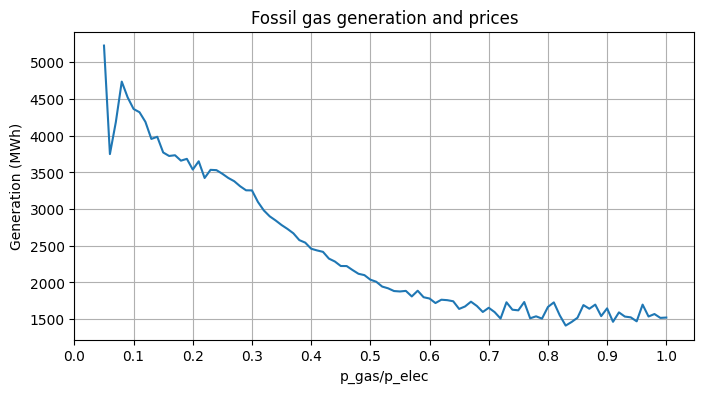

In [35]:
# Create plot for FG
df = production_type_df[['Fossil Gas']].join(hourly_prices_df)
df_1 = df[(df['p_gas/p_elec'] >= 0) & (df['p_gas/p_elec'] <= 1)]

stats_df = df_1 \
               .groupby('p_gas/p_elec')['Fossil Gas']  \
               .agg('mean')

plt.plot(stats_df)
plt.xlabel('p_gas/p_elec')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Generation (MWh)')
plt.title('Fossil gas generation and prices')
plt.grid(visible=True, which='both', axis='both')

#plt.savefig('FG generation and prices.png', bbox_inches='tight')

plt.show()

In [36]:
# Create function to plot generation factor
def plot_perc_time(plant_name):
    
    # Define df
    df = basetable_perc_df[[plant_name, 'p_gas/p_elec']]
    
    # Delete outages
    df_1 = df[(df[plant_name] != -1) & (df['p_gas/p_elec'] >= 0) & (df['p_gas/p_elec'] <= 1)]
    
    # Generate statistics: Frequency
    stats_df = df_1 \
               .groupby('p_gas/p_elec')[plant_name]  \
               .agg(['count', 'sum']) \
               .reset_index() \
               .rename(columns = {'count': 'frequency', 'sum': 'frequency_1'})
    
    # Calculate frequency of 0s and 1s and the ratio of 1s over total 0s and 1s
    stats_df['frequency_0'] = stats_df['frequency'] - stats_df['frequency_1']
    stats_df['ratio_1'] = stats_df['frequency_1'] / stats_df['frequency']
    
    # Assign x, y, y_smooth
    x = stats_df['p_gas/p_elec']
    y = stats_df['ratio_1']
    
    # Set x-axis ticks to 0.1 jumps
    plt.xticks(np.arange(0, 1.1, 0.1))
    
    # Create plots
    plt.plot(x, y)

    plt.xlabel('p_gas/p_elec')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.ylabel('Generation factor')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title('Generation factor plot: ' + plant_name)
    plt.grid(visible='true', which='both', axis='both')
    
    #plt.savefig('GF_plot_' + plant_name + '.png', bbox_inches='tight')
    
    plt.show()

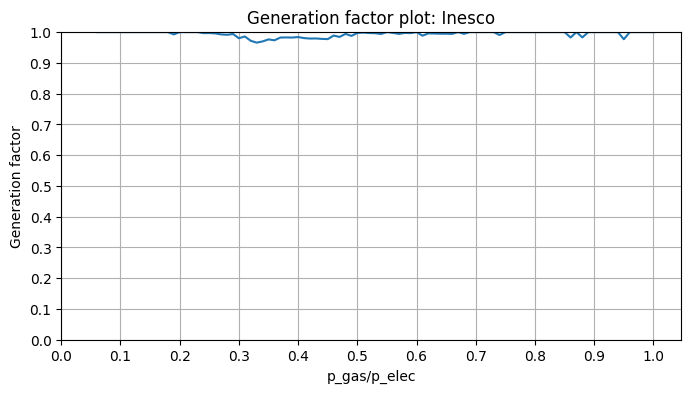

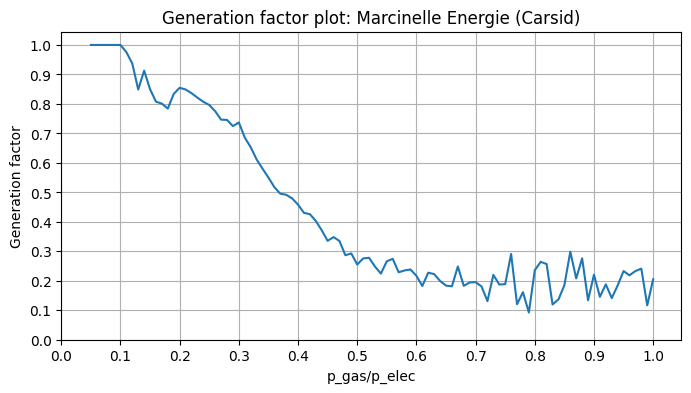

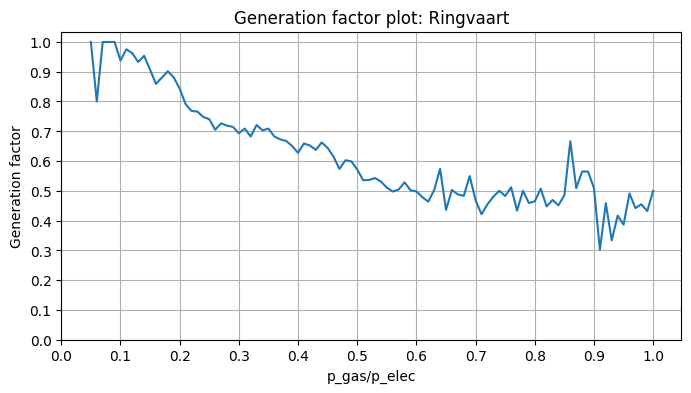

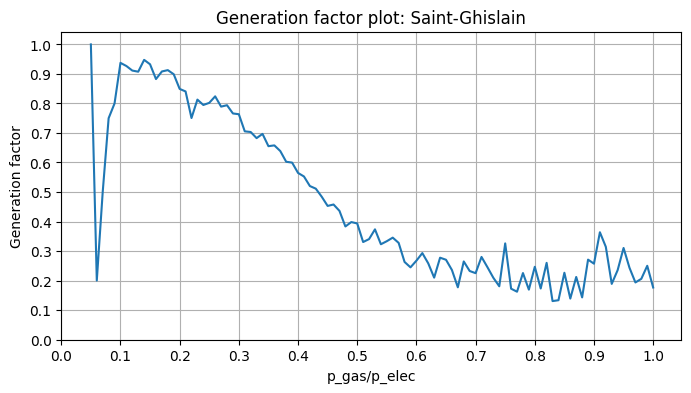

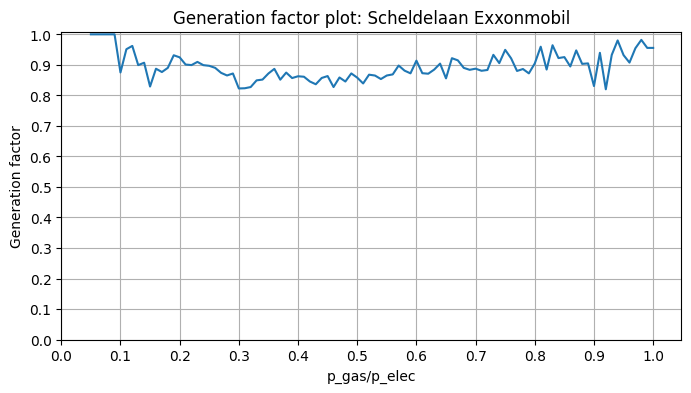

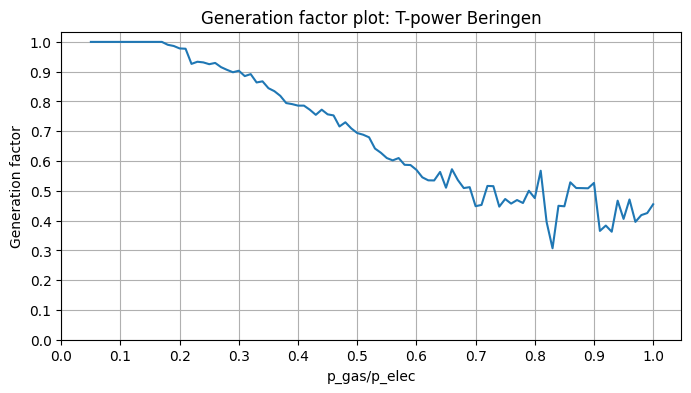

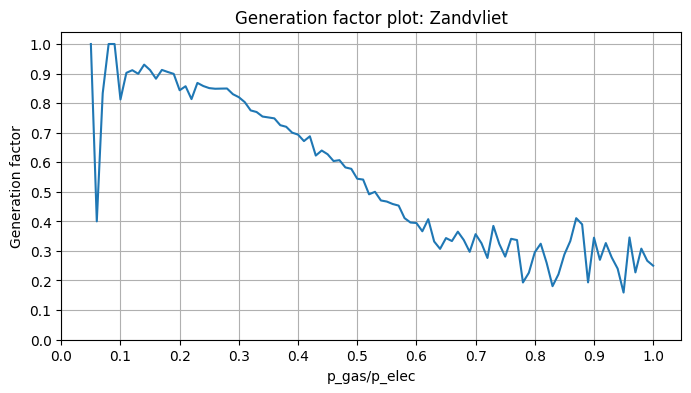

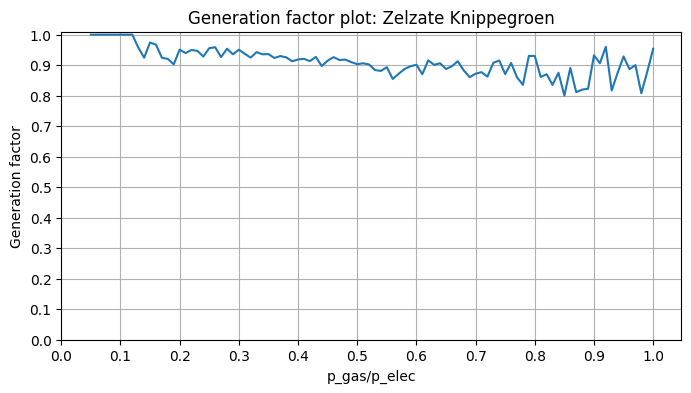

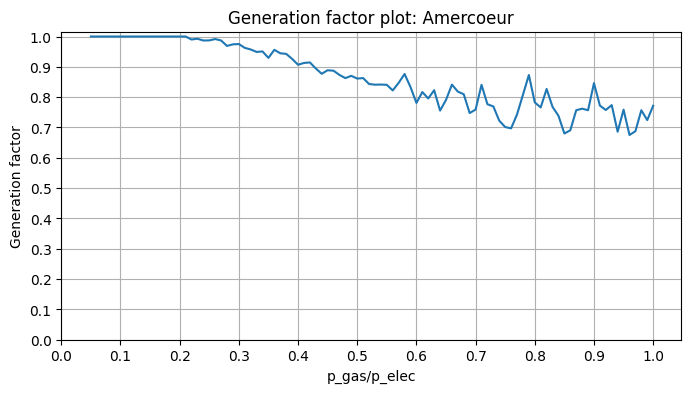

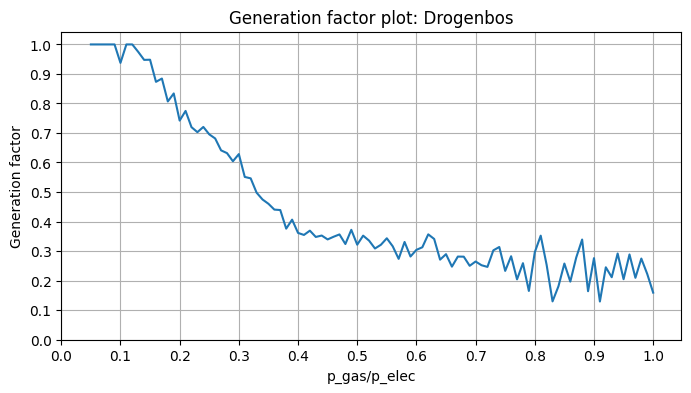

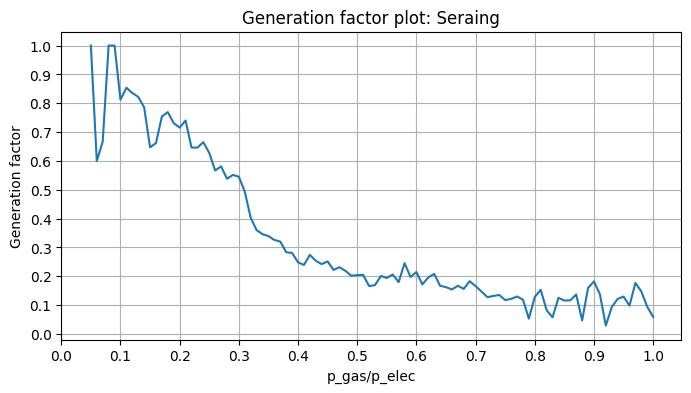

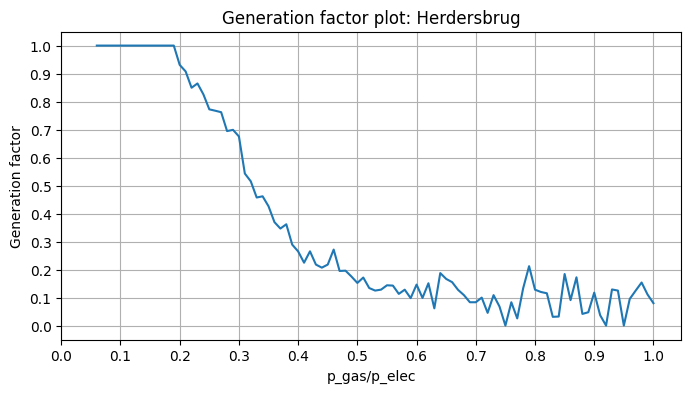

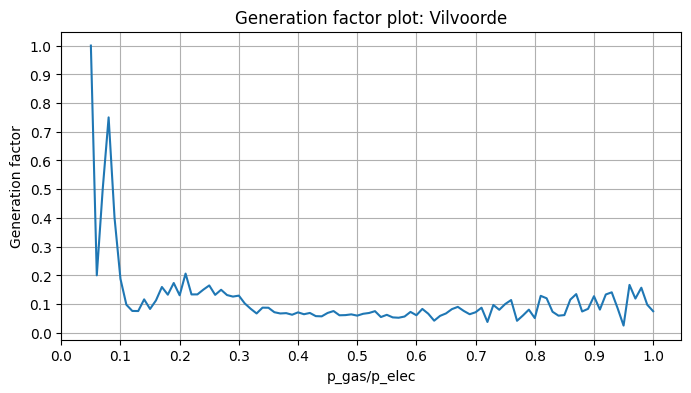

In [37]:
# Show plots
for plant in generation_final_df.columns:
    plot_perc_time(plant)

In [38]:
# Create efficiency dictionary
dict_eff = {}

In [39]:
# Create function to plot % time of generation, with smoothing and kneepoint 
def plot_perc_time_smoothing(plant_name):
    
    # Define df
    df = basetable_perc_df[[plant_name, 'p_gas/p_elec']]
    
    # Delete outages
    df_1 = df[(df[plant_name] != -1) & (df['p_gas/p_elec'] >= 0) & (df['p_gas/p_elec'] <= 1)]
    
    # Generate statistics: Frequency
    stats_df = df_1 \
               .groupby('p_gas/p_elec')[plant_name]  \
               .agg(['count', 'sum']) \
               .reset_index() \
               .rename(columns = {'count': 'frequency', 'sum': 'frequency_1'})
    
    # Calculate frequency of 0s and 1s and the ratio of 1s over total 0s and 1s
    stats_df['frequency_0'] = stats_df['frequency'] - stats_df['frequency_1']
    stats_df['ratio_1'] = stats_df['frequency_1'] / stats_df['frequency']
    
    # Assign x, y, y_smooth
    x = stats_df['p_gas/p_elec']
    y = stats_df['ratio_1']
    y_smooth = savgol_filter(y, window_length=51, polyorder=3)
    
    # Get elbow point
    kn = KneeLocator(x[25:], y_smooth[25:], S=0.7, curve='convex', direction='decreasing')
    
    # Fill in efficiency dictionary
    dict_eff[plant_name] = kn.knee
    
    # Create plots
    # Plot curve
    plt.plot(x, y, label='original curve')
    
    # Plot smooth curve
    plt.plot(x, y_smooth, label='smoothed curve')
    
    # Plot knee
    plt.vlines(kn.knee, 0, 1, linestyles='dashed')

    # Set plot 
    plt.xlabel('p_gas/p_elec')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.ylabel('Generation factor')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title('Efficiency estimation: ' + plant_name)
    plt.grid(visible='true', which='both', axis='both')
    plt.legend(loc='upper right')

    #plt.savefig('GF_efficiency_plot_' + plant_name + '.png', bbox_inches='tight')
    
    plt.show()

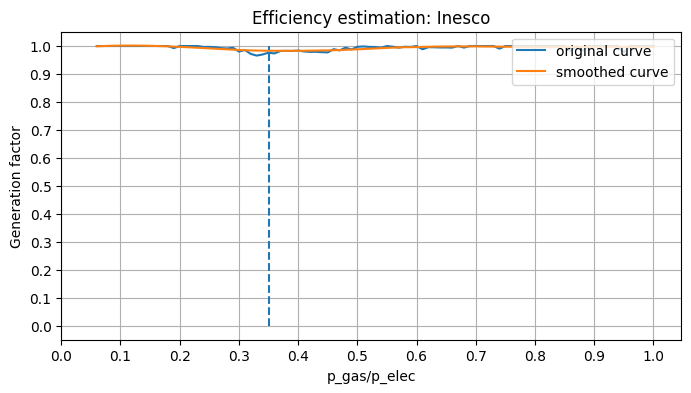

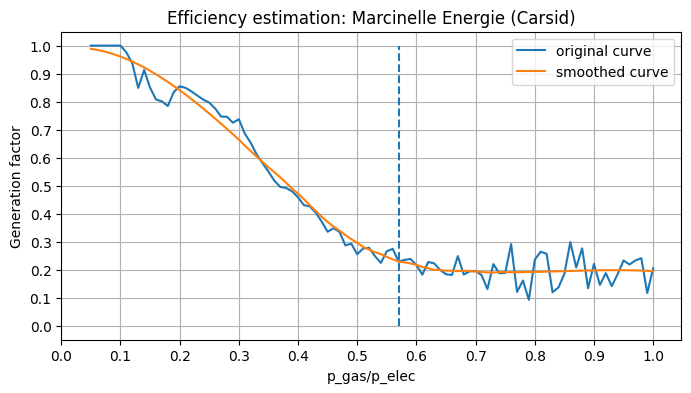

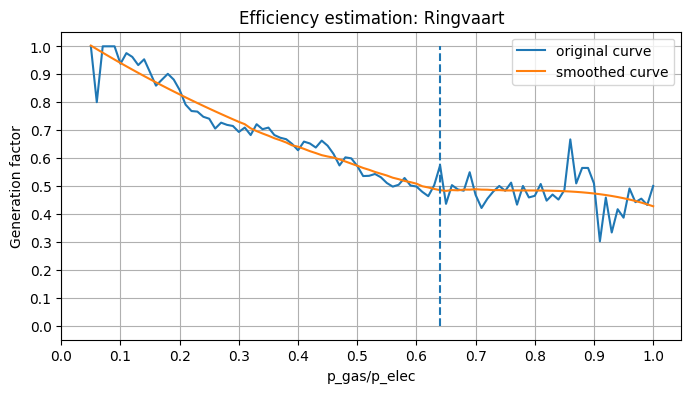

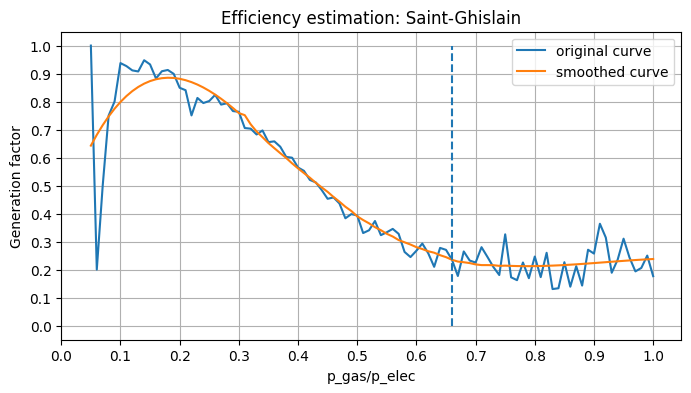

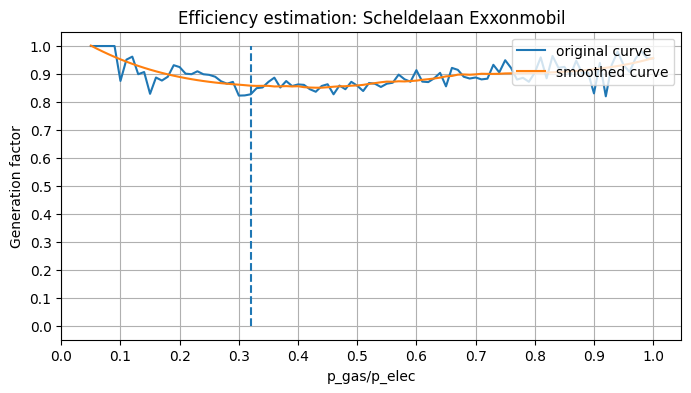

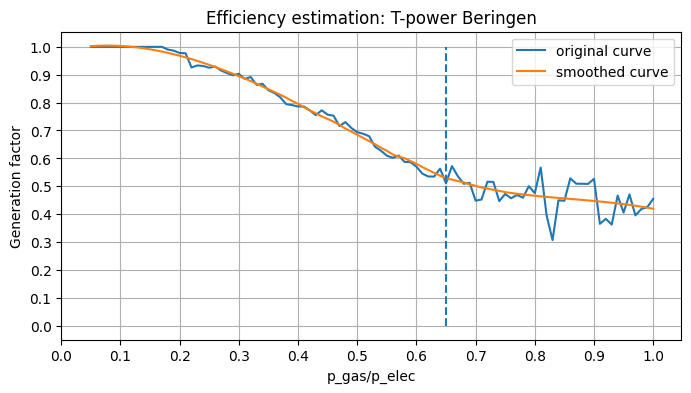

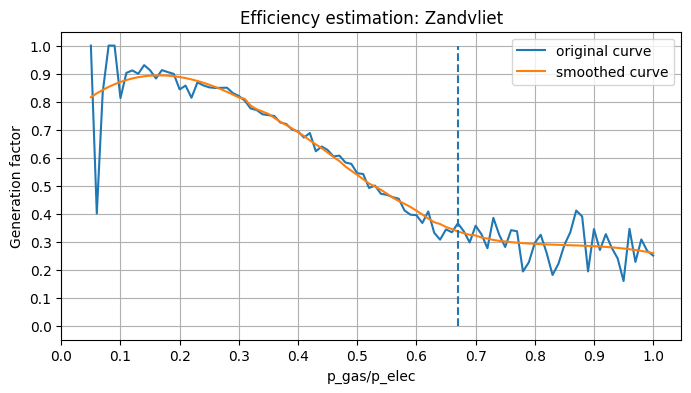

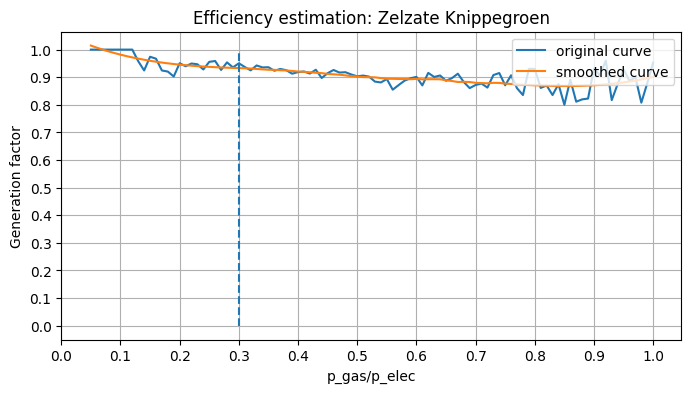

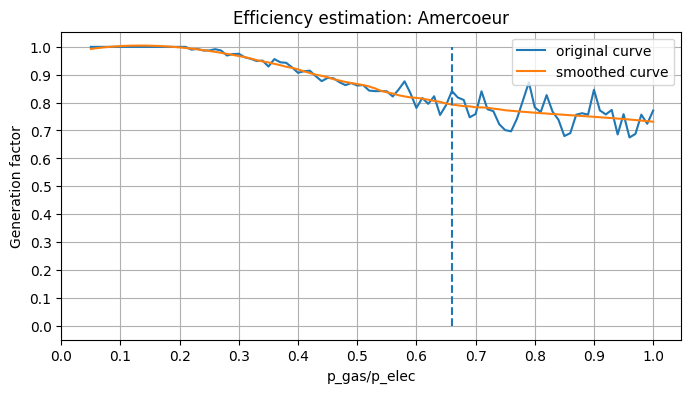

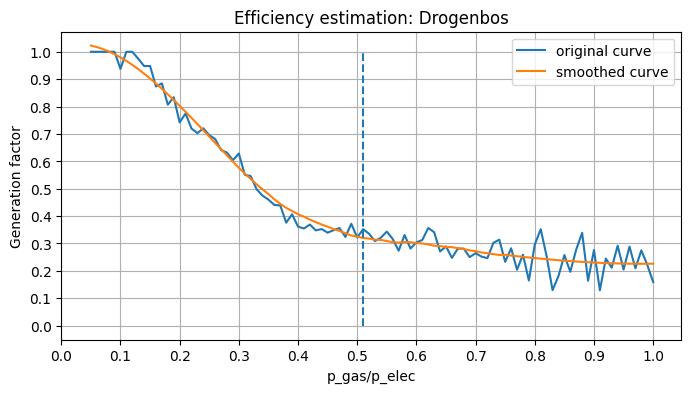

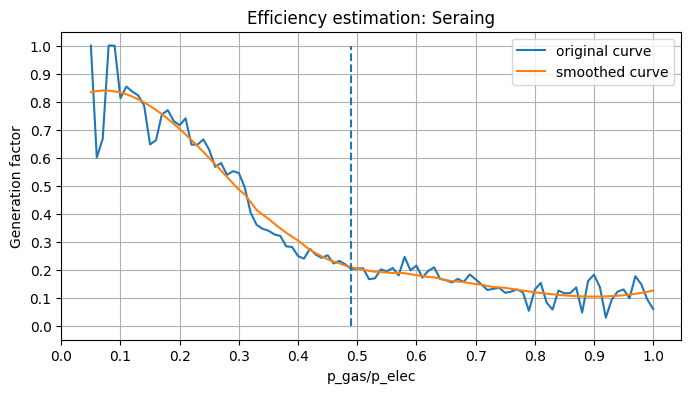

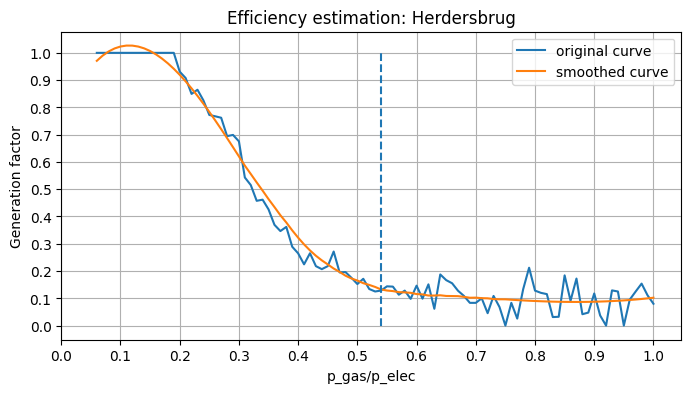

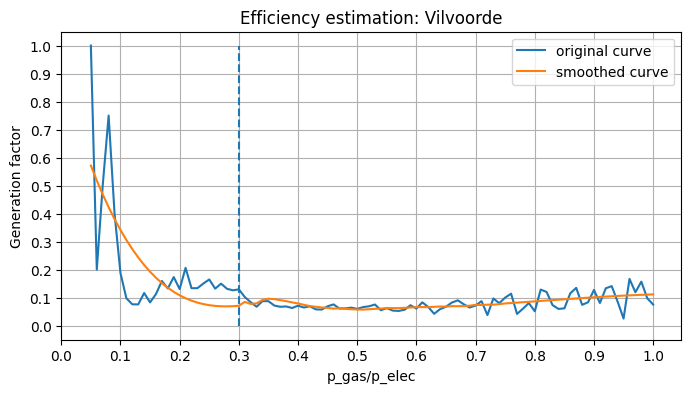

In [40]:
# Show plots with efficiency
for plant in generation_final_df.columns:
    plot_perc_time_smoothing(plant)

In [41]:
# Check efficiencies
dict_eff

{'Inesco': 0.35,
 'Marcinelle Energie (Carsid)': 0.57,
 'Ringvaart': 0.64,
 'Saint-Ghislain': 0.66,
 'Scheldelaan Exxonmobil': 0.32,
 'T-power Beringen': 0.65,
 'Zandvliet': 0.67,
 'Zelzate Knippegroen': 0.3,
 'Amercoeur': 0.66,
 'Drogenbos': 0.51,
 'Seraing': 0.49,
 'Herdersbrug': 0.54,
 'Vilvoorde': 0.3}

# 4. Efficiency df

In [42]:
# Create efficiency df
efficiency_df = pd.DataFrame(dict_eff.values(), index=dict_eff.keys(), columns=['efficiency'])
efficiency_df.index.name = 'plant_name'

In [43]:
# Combine with plant_info
efficiency_df = efficiency_df.join(plant_info_df)

In [44]:
# Only keep market based plants
efficiency_df = efficiency_df[efficiency_df['market_based'] == 1]

In [45]:
# Sort by efficiency
efficiency_df.sort_values(by='efficiency', ascending=False, inplace=True)

In [46]:
# Check
efficiency_df

,efficiency,owner,type,available_capacity (MW),market_based,outage_hours,generation_hours,available_hours,generation_hours/available_hours,outage_hours/total_hours
plant_name,,,,,,,,,,
Zandvliet,0.67,Engie Electrabel,CCGT,386.2,1,844.0,28465.0,44661.0,0.64,0.02
Saint-Ghislain,0.66,Engie Electrabel,CCGT,386.0,1,4267.0,23325.0,41238.0,0.57,0.09
Amercoeur,0.66,Engie Electrabel,CCGT,451.0,1,11793.0,30433.0,33712.0,0.90,0.26
T-power Beringen,0.65,T-Power,CCGT,422.0,1,3794.0,31301.0,41711.0,0.75,0.08
Ringvaart,0.64,Luminus,CCGT,385.0,1,684.0,28347.0,44821.0,0.63,0.02
Marcinelle Energie (Carsid),0.57,Direct Energie,CCGT,413.0,1,176.0,20952.0,45329.0,0.46,0.00
Herdersbrug,0.54,Engie Electrabel,CCGT,480.3,1,29796.0,5808.0,15709.0,0.37,0.65
Drogenbos,0.51,Engie Electrabel,CCGT,460.0,1,676.0,19485.0,44829.0,0.43,0.01
Seraing,0.49,Luminus,CCGT,470.0,1,5202.0,13011.0,40303.0,0.32,0.11


# 5. Merit Order

## 5.1 Marginal costs

In [181]:
# Create df to plot evolution over time
mc_evolution_df = daily_prices_df.loc[:,['gas_price', 'day_ahead_price']]

In [185]:
# Create columns
mc_evolution_df['minimal mc'] = round(mc_evolution_df['gas_price']/efficiency_df['efficiency'].max(),2)
mc_evolution_df['mean mc'] = round(mc_evolution_df['gas_price']/efficiency_df['efficiency'].mean(),2)
mc_evolution_df['maximal mc'] = round(mc_evolution_df['gas_price']/efficiency_df['efficiency'].min(),2)

In [186]:
# Check
mc_evolution_df.head(5)

,gas_price,day_ahead_price,minimal mc,mean mc,maximal mc
date,,,,,
2017-10-23 00:00:00+02:00,18.09,65.805000,27.00,31.79,60.30
2017-10-24 00:00:00+02:00,17.96,52.650000,26.81,31.56,59.87
2017-10-25 00:00:00+02:00,18.11,58.244167,27.03,31.83,60.37
2017-10-26 00:00:00+02:00,18.07,64.522917,26.97,31.76,60.23
2017-10-27 00:00:00+02:00,18.15,53.442083,27.09,31.90,60.50


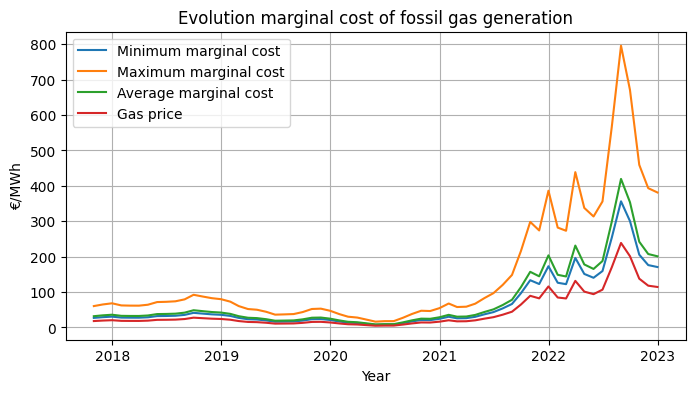

In [104]:
# Plot
plt.plot(mc_evolution_df.resample('M').mean().index, mc_evolution_df['minimal mc'].resample('M').mean(), label='Minimum marginal cost')
plt.plot(mc_evolution_df.resample('M').mean().index, mc_evolution_df['maximal mc'].resample('M').mean(), label='Maximum marginal cost')
plt.plot(mc_evolution_df.resample('M').mean().index, mc_evolution_df['mean mc'].resample('M').mean(), label='Average marginal cost')
plt.plot(mc_evolution_df.resample('M').mean().index, mc_evolution_df['gas_price'].resample('M').mean(), label='Gas price')

plt.xlabel('Year')
plt.ylabel('€/MWh')
plt.title('Evolution marginal cost of fossil gas generation')
plt.grid(visible='True', which='both', axis='both')
plt.legend()

#plt.savefig('MC_evolution.png', bbox_inches='tight')

plt.show()

## 5.2 Merit Order Curves

In [159]:
# Create merit order df
merit_order_df = efficiency_df.loc[:,['efficiency', 'available_capacity (MW)']]

In [160]:
# Check
merit_order_df

,efficiency,available_capacity (MW)
plant_name,,
Zandvliet,0.67,386.2
Saint-Ghislain,0.66,386.0
Amercoeur,0.66,451.0
T-power Beringen,0.65,422.0
Ringvaart,0.64,385.0
Marcinelle Energie (Carsid),0.57,413.0
Herdersbrug,0.54,480.3
Drogenbos,0.51,460.0
Seraing,0.49,470.0


In [161]:
# Create MC of generation column for each plant, self chosen gas prices
merit_order_df['mc_generation_40'] = round(40 / merit_order_df['efficiency'], 2)
merit_order_df['mc_generation_60'] = round(60 / merit_order_df['efficiency'], 2)
merit_order_df['mc_generation_80'] = round(80 / merit_order_df['efficiency'], 2)
merit_order_df['mc_generation_100'] = round(100 / merit_order_df['efficiency'], 2)

In [162]:
# Create MC of generation from interesting gas prices in the dataset
merit_order_df['mc_generation_mean'] = round(hourly_prices_df['gas_price'].mean()/merit_order_df['efficiency'], 2)
merit_order_df['mc_generation_pre_crisis'] = round(hourly_prices_df.loc[:'2021-04-01','gas_price'].mean()/merit_order_df['efficiency'], 2)
merit_order_df['mc_generation_crisis'] = round(hourly_prices_df.loc['2021-04-01':,'gas_price'].mean()/merit_order_df['efficiency'], 2)

In [163]:
# Check gas price values
print(hourly_prices_df['gas_price'].mean())
print(hourly_prices_df.loc[:'2021-04-01','gas_price'].mean())
print(hourly_prices_df.loc['2021-04-01':,'gas_price'].mean())

44.17803436984946
15.950023037655793
99.57693112427577


In [164]:
# Check
merit_order_df

,efficiency,available_capacity (MW),mc_generation_40,mc_generation_60,mc_generation_80,mc_generation_100,mc_generation_mean,mc_generation_pre_crisis,mc_generation_crisis
plant_name,,,,,,,,,
Zandvliet,0.67,386.2,59.70,89.55,119.40,149.25,65.94,23.81,148.62
Saint-Ghislain,0.66,386.0,60.61,90.91,121.21,151.52,66.94,24.17,150.87
Amercoeur,0.66,451.0,60.61,90.91,121.21,151.52,66.94,24.17,150.87
T-power Beringen,0.65,422.0,61.54,92.31,123.08,153.85,67.97,24.54,153.20
Ringvaart,0.64,385.0,62.50,93.75,125.00,156.25,69.03,24.92,155.59
Marcinelle Energie (Carsid),0.57,413.0,70.18,105.26,140.35,175.44,77.51,27.98,174.70
Herdersbrug,0.54,480.3,74.07,111.11,148.15,185.19,81.81,29.54,184.40
Drogenbos,0.51,460.0,78.43,117.65,156.86,196.08,86.62,31.27,195.25
Seraing,0.49,470.0,81.63,122.45,163.27,204.08,90.16,32.55,203.22


In [165]:
# Cumulative capacity
merit_order_df['cumulative_capacity (MW)'] = merit_order_df['available_capacity (MW)'].cumsum()

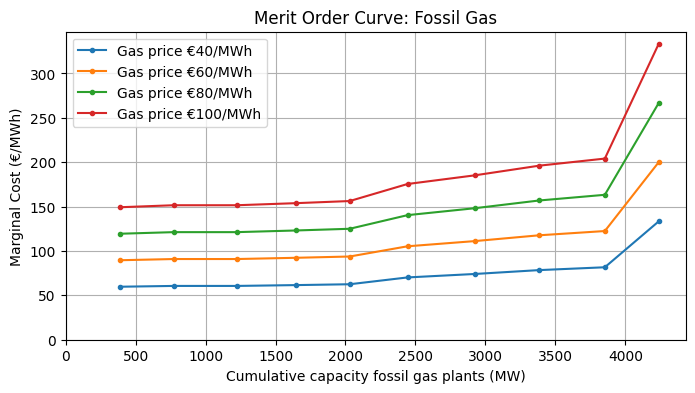

In [166]:
# Plot
plt.plot(merit_order_df['cumulative_capacity (MW)'], merit_order_df['mc_generation_40'], label='Gas price €40/MWh', marker='.')
plt.plot(merit_order_df['cumulative_capacity (MW)'], merit_order_df['mc_generation_60'], label='Gas price €60/MWh', marker='.')
plt.plot(merit_order_df['cumulative_capacity (MW)'], merit_order_df['mc_generation_80'], label='Gas price €80/MWh', marker='.')
plt.plot(merit_order_df['cumulative_capacity (MW)'], merit_order_df['mc_generation_100'], label='Gas price €100/MWh', marker='.')

plt.xlabel('Cumulative capacity fossil gas plants (MW)')
plt.ylabel('Marginal Cost (€/MWh)')
plt.xlim(0)
plt.ylim(0)
plt.title('Merit Order Curve: Fossil Gas')
plt.legend(loc='best')
plt.grid(visible='true', which='both', axis='both')

#plt.savefig('MOC_gasprices_chosen.png', bbox_inches='tight')

plt.show()

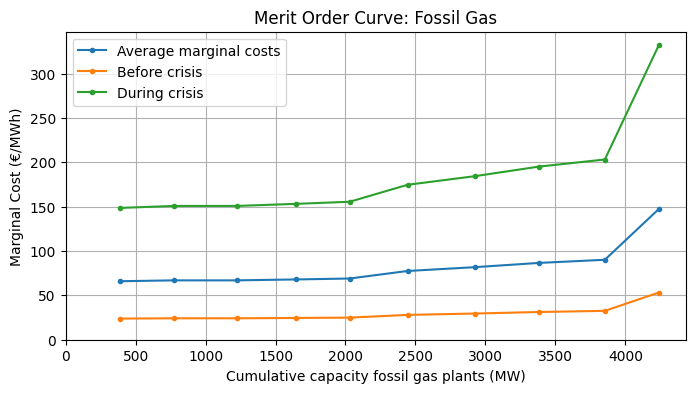

In [187]:
# Plot
plt.plot(merit_order_df['cumulative_capacity (MW)'], merit_order_df['mc_generation_mean'], label='Average marginal costs', marker='.')
plt.plot(merit_order_df['cumulative_capacity (MW)'], merit_order_df['mc_generation_pre_crisis'], label='Before crisis', marker='.')
plt.plot(merit_order_df['cumulative_capacity (MW)'], merit_order_df['mc_generation_crisis'], label='During crisis', marker='.')

plt.xlabel('Cumulative capacity fossil gas plants (MW)')
plt.ylabel('Marginal Cost (€/MWh)')
plt.xlim(0)
plt.ylim(0)
plt.title('Merit Order Curve: Fossil Gas')
plt.legend(loc='best')
plt.grid(visible='true', which='both', axis='both')

plt.savefig('MOC_gasprices_data.png', bbox_inches='tight')

plt.show()